In [1]:
import pandas as pd
import numpy as np

In [0]:
"""
metrics.py
Clustering evaluation metrics for algorithms that assign single labels (no meta-clusters)
-1 indicates outliers
"""

import numpy as np
from itertools import combinations
from scipy.special import comb

def Re(original_label, pred_label):
    """
    Error Rate (Re)
    
    Calculates the ratio of misclassifications to total number of objects.
    
    Definition: Re = Ne / N
    where Ne = number of misclassifications
          N  = total number of objects
    
    Misclassification occurs when:
    1. pred_label[i] != original_label[i] (wrong cluster assignment)
    2. pred_label[i] == -1 (outlier) but original_label[i] is not an outlier*
    
    *Note: Assumes original_label has no outlier class (-1)
    
    Parameters:
    -----------
    original_label : array-like, shape (n_samples,)
        Ground truth cluster assignments (non-negative integers)
    pred_label : array-like, shape (n_samples,)
        Predicted cluster assignments (-1 for outliers)
        
    Returns:
    --------
    re : float
        Error rate (0 to 1, lower is better)
    """
    n = len(original_label)
    if n == 0:
        return 0.0
    
    ne = 0  # Number of misclassifications
    
    for i in range(n):
        true_cluster = original_label[i]
        pred_cluster = pred_label[i]
        
        # Misclassification if:
        # 1. Wrong cluster assignment
        # 2. Predicted as outlier (-1) but true is not outlier
        if pred_cluster == -1:
            # If predicted as outlier, always misclassification 
            # (since original_label has no outlier class)
            ne += 1
        elif pred_cluster != true_cluster:
            ne += 1
    
    return ne / n

def Ri(original_label, pred_label):
    """
    Imprecision Rate (Ri)
    
    In your algorithm without meta-clusters, this should always return 0
    since there are no meta-cluster assignments.
    
    Definition: Ri = Ni / N
    where Ni = number of objects in meta-clusters
          N  = total number of objects
    
    Parameters:
    -----------
    original_label : array-like, shape (n_samples,)
        Ground truth cluster assignments
    pred_label : array-like, shape (n_samples,)
        Predicted cluster assignments
        
    Returns:
    --------
    ri : float
        Always 0 (no meta-clusters)
    """
    return 0.0

def EP(original_label, pred_label):
    """
    Evidential Precision (EP) - Simplified for single label assignments
    
    Measures precision of non-outlier assignments.
    
    Definition: EP = TP* / (TP* + FP*)
    where TP* = number of pairs of similar objects (same true cluster) 
                that are both assigned to the same cluster (and not outliers)
          FP* = number of pairs of dissimilar objects (different true clusters)
                that are both assigned to the same cluster (and not outliers)
    
    Only considers pairs where both objects are NOT outliers (pred_label != -1)
    
    Parameters:
    -----------
    original_label : array-like, shape (n_samples,)
        Ground truth cluster assignments
    pred_label : array-like, shape (n_samples,)
        Predicted cluster assignments (-1 for outliers)
        
    Returns:
    --------
    ep : float
        Evidential precision (0 to 1, higher is better)
    """
    n = len(original_label)
    
    # Find indices of non-outlier predictions
    non_outlier_indices = [i for i in range(n) if pred_label[i] != -1]
    
    if len(non_outlier_indices) < 2:
        return 0.0  # Need at least 2 non-outliers to compute pairs
    
    tp_star = 0  # True positive pairs (similar objects in same cluster)
    fp_star = 0  # False positive pairs (dissimilar objects in same cluster)
    
    # Consider all pairs of non-outlier objects
    for i, j in combinations(non_outlier_indices, 2):
        if i >= j:
            continue
            
        true_i = original_label[i]
        true_j = original_label[j]
        pred_i = pred_label[i]
        pred_j = pred_label[j]
        
        # Check if assigned to the same cluster
        if pred_i == pred_j:
            if true_i == true_j:
                tp_star += 1
            else:
                fp_star += 1
    
    denominator = tp_star + fp_star
    return tp_star / denominator if denominator > 0 else 0.0

def ERI(original_label, pred_label):
    """
    Evidential Rank Index (ERI) - Simplified for single label assignments
    
    Comprehensive evaluation considering both beneficial and detrimental elements.
    
    Definition: ERI = 2(TP* + TN*) / [N(N-1)]
    where TP* = number of pairs of similar objects (same true cluster) 
                that are both assigned to the same cluster (and not outliers)
          TN* = number of pairs of dissimilar objects (different true clusters)
                that are assigned to different clusters (and both not outliers)
          N   = total number of objects
    
    Only considers pairs where both objects are NOT outliers (pred_label != -1)
    
    Parameters:
    -----------
    original_label : array-like, shape (n_samples,)
        Ground truth cluster assignments
    pred_label : array-like, shape (n_samples,)
        Predicted cluster assignments (-1 for outliers)
        
    Returns:
    --------
    eri : float
        Evidential rank index (0 to 1, higher is better)
    """
    n = len(original_label)
    
    if n < 2:
        return 0.0
    
    # Find indices of non-outlier predictions
    non_outlier_indices = [i for i in range(n) if pred_label[i] != -1]
    
    tp_star = 0  # True positive pairs
    tn_star = 0  # True negative pairs
    
    # Consider all pairs of non-outlier objects
    for i, j in combinations(non_outlier_indices, 2):
        if i >= j:
            continue
            
        true_i = original_label[i]
        true_j = original_label[j]
        pred_i = pred_label[i]
        pred_j = pred_label[j]
        
        same_true = (true_i == true_j)
        same_pred = (pred_i == pred_j)
        
        if same_true and same_pred:
            tp_star += 1
        elif (not same_true) and (not same_pred):
            tn_star += 1
    
    total_pairs = n * (n - 1)
    return 2 * (tp_star + tn_star) / total_pairs if total_pairs > 0 else 0.0

def rand_index(original_label, pred_label):
    """
    Rand Index (RI) - Standard version
    
    Measures the similarity between two data clusterings.
    
    Definition: RI = (TP + TN) / (TP + FP + FN + TN)
    where TP = number of pairs of similar objects (same true cluster) 
               that are both assigned to the same predicted cluster
          TN = number of pairs of dissimilar objects (different true clusters)
               that are assigned to different predicted clusters
          FP = number of pairs of dissimilar objects 
               that are assigned to the same predicted cluster
          FN = number of pairs of similar objects 
               that are assigned to different predicted clusters
    
    Treats -1 (outliers) as a separate cluster.
    
    Parameters:
    -----------
    original_label : array-like, shape (n_samples,)
        Ground truth cluster assignments
    pred_label : array-like, shape (n_samples,)
        Predicted cluster assignments
        
    Returns:
    --------
    ri : float
        Rand Index (0 to 1, higher is better)
    """
    n = len(original_label)
    
    if n < 2:
        return 0.0
    
    tp = 0  # True positives
    tn = 0  # True negatives
    fp = 0  # False positives
    fn = 0  # False negatives
    
    # Consider all pairs of objects
    for i, j in combinations(range(n), 2):
        if i >= j:
            continue
            
        true_i = original_label[i]
        true_j = original_label[j]
        pred_i = pred_label[i]
        pred_j = pred_label[j]
        
        same_true = (true_i == true_j)
        same_pred = (pred_i == pred_j)
        
        if same_true and same_pred:
            tp += 1
        elif same_true and not same_pred:
            fn += 1
        elif not same_true and same_pred:
            fp += 1
        else:  # not same_true and not same_pred
            tn += 1
    
    total = tp + tn + fp + fn
    return (tp + tn) / total if total > 0 else 0.0

def adjusted_rand_index(original_label, pred_label):
    """
    Adjusted Rand Index (ARI)
    
    Adjusted for chance version of the Rand Index.
    
    Definition: ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)
    where RI = Rand Index
          Expected_RI = expected value of RI under random assignment
    
    Parameters:
    -----------
    original_label : array-like, shape (n_samples,)
        Ground truth cluster assignments
    pred_label : array-like, shape (n_samples,)
        Predicted cluster assignments
        
    Returns:
    --------
    ari : float
        Adjusted Rand Index (-1 to 1, higher is better, 0 = random)
    """
    n = len(original_label)
    
    if n < 2:
        return 0.0
    
    # Create contingency table
    true_clusters = np.unique(original_label)
    pred_clusters = np.unique(pred_label)
    
    # Create contingency matrix
    contingency = np.zeros((len(true_clusters), len(pred_clusters)), dtype=int)
    
    # Map clusters to indices
    true_to_idx = {cluster: idx for idx, cluster in enumerate(true_clusters)}
    pred_to_idx = {cluster: idx for idx, cluster in enumerate(pred_clusters)}
    
    # Fill contingency matrix
    for i in range(n):
        true_idx = true_to_idx[original_label[i]]
        pred_idx = pred_to_idx[pred_label[i]]
        contingency[true_idx, pred_idx] += 1
    
    # Calculate row and column sums
    a = contingency.sum(axis=1)  # Row sums
    b = contingency.sum(axis=0)  # Column sums
    
    # Calculate index (sum over cells of n_ij choose 2)
    index = np.sum([comb(n_ij, 2) for n_ij in contingency.flatten() if n_ij >= 2])
    
    # Calculate expected index
    sum_ai = np.sum([comb(ai, 2) for ai in a if ai >= 2])
    sum_bj = np.sum([comb(bj, 2) for bj in b if bj >= 2])
    expected_index = sum_ai * sum_bj / comb(n, 2)
    
    # Calculate max index
    max_index = (sum_ai + sum_bj) / 2
    
    # Calculate ARI
    if max_index == expected_index:
        return 0.0
    else:
        ari = (index - expected_index) / (max_index - expected_index)
        return ari

def compute_all_metrics(original_label, pred_label):
    """
    Compute all 6 clustering metrics.
    
    Parameters:
    -----------
    original_label : array-like, shape (n_samples,)
        Ground truth cluster assignments
    pred_label : array-like, shape (n_samples,)
        Predicted cluster assignments (-1 for outliers)
        
    Returns:
    --------
    metrics : dict
        Dictionary containing all metrics
    """
    metrics = {}
    
    # Evidential clustering metrics (simplified)
    metrics['Re'] = Re(original_label, pred_label)
    metrics['Ri'] = Ri(original_label, pred_label)  # Always 0
    metrics['EP'] = EP(original_label, pred_label)
    metrics['ERI'] = ERI(original_label, pred_label)
    
    # Standard clustering metrics
    metrics['RI'] = rand_index(original_label, pred_label)
    metrics['ARI'] = adjusted_rand_index(original_label, pred_label)
    
    return metrics

In [2]:
def _init_centers(X, c, random_state=None):
    """
    Initialize cluster centers by filling missing values with column means
    and picking random rows as initial centers.
    """
    rng = np.random.default_rng(random_state)
    X = np.asarray(X, dtype=float)
    n, s = X.shape
    mask = ~np.isnan(X)
    col_means = np.where(mask, X, np.nan).mean(axis=0)
    X_filled = np.where(mask, X, col_means)
    idx = rng.choice(n, size=c, replace=False)
    return X_filled[idx]


In [3]:
def _compute_partial_distances(X, V, mask):
    """
    Compute squared partial distances d_ij^2 between each object and each center:
      d_ij^2 = sum_p lambda_ip (x_ip - v_jp)^2
    where lambda_ip = 1 if observed, 0 if missing.
    """
    # X_zero has 0 for missing values to avoid nan propagation
    X_zero = np.where(mask, X, 0.0)
    # shape: (n, c, s)
    diff = X_zero[:, None, :] - V[None, :, :]
    # mask3: (n, 1, s) -> broadcast to (n, c, s)
    mask3 = mask[:, None, :]
    diff_masked = diff * mask3
    d2 = (diff_masked ** 2).sum(axis=2)  # (n, c)
    return d2


In [4]:
def _update_memberships(d2, beta, delta2):
    """
    Update membership masses m_ij and m_i_empty (for outliers) given distances d2.
    Uses formulas (10) in the paper with numeric stabilisation.
    """
    power = -1.0 / (beta - 1.0)
    # avoid division by zero
    d2_safe = d2 + 1e-12
    tmp = d2_safe ** power  # shape (n, c)
    delta_term = (delta2 + 1e-12) ** power
    denom = tmp.sum(axis=1, keepdims=True) + delta_term  # shape (n, 1)
    m = tmp / denom  # m_ij
    m_empty = delta_term / denom.squeeze()  # m_i∅
    return m, m_empty


In [5]:
def _update_centers(X, mask, M, beta):
    """
    Update cluster centers via formula (11).
    """
    n, s = X.shape
    c = M.shape[1]
    V = np.zeros((c, s), dtype=float)
    m_beta = M ** beta  # (n, c)
    X_valid = np.where(np.isnan(X), 0, X)  # Replace nan with 0 for calculation
    valid_mask = (~np.isnan(X)).astype(float)  # 1 where not nan, 0 where nan

    for j in range(c):
        w = m_beta[:, j:j+1] * mask  # (n, s)
        w_valid = w * valid_mask     # zero out weights where X is nan
        num = (w_valid * X_valid).sum(axis=0)    # (s,)
        den = w_valid.sum(axis=0)                # (s,)
        with np.errstate(divide='ignore', invalid='ignore'):
            v_j = np.where(den > 0, num / den, 0.0)
        V[j] = v_j
    return V

In [6]:
# ============================================================
#  Step 1: Preliminary partial-distance evidential clustering
# ============================================================

def preliminary_pec(X, c, beta=2.0, eps=1e-4, max_iter=200, random_state=None):
    """
    Step 1: Perform evidential clustering with partial distances (no imputation).
    Returns:
      V          : final cluster centers (c, s)
      M          : mass matrix for singleton clusters (n, c)
      m_empty    : mass vector for outlier (n,)
      info       : dict with Lambda sets, completeness, and preliminary labels
    """
    X = np.asarray(X, dtype=float)
    n, s = X.shape
    mask = ~np.isnan(X)  # True if observed

    # 1) Initialize centers
    V = _init_centers(X, c, random_state=random_state)

    # 2) Iterative optimization of objective (5)
    for _ in range(max_iter):
        V_prev = V.copy()
        # distances and delta^2 (7)
        d2 = _compute_partial_distances(X, V, mask)  # (n, c)
        delta2 = d2.sum() / (c * n)
        # memberships (10)
        M, m_empty = _update_memberships(d2, beta, delta2)
        # centers (11)
        V = _update_centers(X, mask, M, beta)
        # check convergence
        if np.linalg.norm(V - V_prev) < eps:
            break

    # 3) Compute threshold phi (14)
    m_bar = M.mean(axis=1, keepdims=True)   # (n,1)
    phi = ((M - m_bar) ** 2).mean()         # scalar

    # 4) Compute Lambda_i sets and preliminary labels
    Lambda = []
    is_complete = mask.all(axis=1)  # (n,)

    prelim_type = np.empty(n, dtype=object)
    prelim_cluster = np.full(n, -1, dtype=int)  # singleton cluster index or -1
    # 'noise' = pure outlier; 'singleton' = definite cluster; 'meta' = meta-cluster; 'uncertain_incomplete' = go to Step 2

    for i in range(n):
        # extended masses: index 0 = empty, 1..c = clusters 0..c-1
        masses = np.concatenate(([m_empty[i]], M[i]))  # shape (c+1,)
        max_idx = np.argmax(masses)
        max_val = masses[max_idx]

        Lambda_i = set()
        for j in range(c + 1):
            if abs(max_val - masses[j]) < phi:
                if j == 0:
                    Lambda_i.add('empty')
                else:
                    Lambda_i.add(j - 1)
        Lambda.append(Lambda_i)

        # classify preliminarily
        if len(Lambda_i) == 0:
            prelim_type[i] = 'noise'
            prelim_cluster[i] = -1
        elif len(Lambda_i) == 1 and 'empty' in Lambda_i:
            prelim_type[i] = 'noise'
            prelim_cluster[i] = -1
        elif len(Lambda_i) == 1 and 'empty' not in Lambda_i:
            # definite singleton cluster
            prelim_type[i] = 'singleton'
            (g,) = Lambda_i
            prelim_cluster[i] = g
        else:
            # ambiguous between >=2 elements
            if is_complete[i]:
                prelim_type[i] = 'meta'
                prelim_cluster[i] = -1
            else:
                prelim_type[i] = 'uncertain_incomplete'
                prelim_cluster[i] = -1

    info = {
        "mask": mask,
        "Lambda": Lambda,
        "is_complete": is_complete,
        "prelim_type": prelim_type,
        "prelim_cluster": prelim_cluster,
        "delta2": delta2
    }
    return V, M, m_empty, info

In [7]:
# ============================================================
#  Step 2: Multiple imputation + DST redistribution
# ============================================================

def _single_membership_from_distances(d2_row, beta, delta2):
    """
    Compute membership (m_j, m_empty) for a single object given distances d2_row (shape (c,)).
    """
    power = -1.0 / (beta - 1.0)
    d2_safe = d2_row + 1e-12
    tmp = d2_safe ** power
    delta_term = (delta2 + 1e-12) ** power
    denom = tmp.sum() + delta_term
    m = tmp / denom
    m_empty = delta_term / denom
    return m, m_empty


def _softmax_negative(distances):
    """
    Turn distances (list/array) into reliability factors via softmax(-d).
    """
    d = np.asarray(distances, dtype=float)
    m = d.min()
    exp_vals = np.exp(-(d - m))  # stabilise
    s = exp_vals.sum()
    if s == 0:
        return np.ones_like(distances) / len(distances)
    return exp_vals / s


def _build_bba_from_membership(m_clusters, m_empty, c):
    """
    Build a basic belief assignment (BBA) dict from membership vector and outlier mass.
    Keys:
      'empty' -> m_empty
      0..c-1  -> m_clusters[j]
    """
    bba = {'empty': float(m_empty)}
    for j in range(c):
        bba[j] = float(m_clusters[j])
    return bba


def _discount_bba_with_meta(bba, alpha, cluster_candidates, c):
    """
    Apply reliability discounting as in (20)-(21), placing uncertainty
    on the meta-cluster corresponding to cluster_candidates.
    Returns a new BBA with keys: 'empty', 0..c-1, 'meta'.
    """
    # original masses
    m_empty = bba.get('empty', 0.0)
    m_clusters = np.array([bba.get(j, 0.0) for j in range(c)], dtype=float)

    m_tilde = {}
    m_tilde['empty'] = m_empty
    # discounted singletons
    m_tilde_clusters = alpha * m_clusters
    for j in range(c):
        m_tilde[j] = float(m_tilde_clusters[j])

    # meta mass
    meta_mass = 1.0 - m_empty - m_tilde_clusters.sum()
    # clip for numerical stability
    meta_mass = max(0.0, min(1.0, meta_mass))
    m_tilde['meta'] = meta_mass
    return m_tilde


def _subset_from_key(key, cluster_candidates_set):
    """
    Map a BBA key to a subset of Ω:
      'empty' -> empty set
      int j   -> {j}
      'meta'  -> cluster_candidates_set
    """
    if key == 'empty':
        return frozenset()
    elif key == 'meta':
        return frozenset(cluster_candidates_set)
    else:
        return frozenset([key])


def _key_from_subset(subset, cluster_candidates_set):
    """
    Map subset back to a key. We only allow:
      ∅       -> 'empty'
      {j}     -> j
      full Λ  -> 'meta'
    """
    if len(subset) == 0:
        return 'empty'
    if subset == frozenset(cluster_candidates_set):
        return 'meta'
    if len(subset) == 1:
        (j,) = tuple(subset)
        return j
    # In this implementation, we don't create new meta-clusters besides Λ;
    # any other subset is ignored (it should not appear in our restricted setup).
    return None


def _fuse_two_bbas(bba1, bba2, cluster_candidates_set, c):
    """
    Fuse two BBAs using the modified Dempster–Shafer rule (22)-(23).
    Keys: 'empty', 0..c-1, 'meta'.
    """
    keys = ['empty'] + list(range(c)) + ['meta']

    # compute conflict K
    K = 0.0
    for B in keys:
        for C in keys:
            if B == 'empty' or C == 'empty':
                continue
            setB = _subset_from_key(B, cluster_candidates_set)
            setC = _subset_from_key(C, cluster_candidates_set)
            inter = setB & setC
            if len(inter) == 0:
                K += bba1.get(B, 0.0) * bba2.get(C, 0.0)

    denom = 1.0 - K + 1e-12

    # fuse non-empty subsets
    num = {k: 0.0 for k in keys}
    for B in keys:
        for C in keys:
            setB = _subset_from_key(B, cluster_candidates_set)
            setC = _subset_from_key(C, cluster_candidates_set)
            inter = setB & setC
            keyA = _key_from_subset(inter, cluster_candidates_set)
            if keyA is None:
                continue
            num[keyA] += bba1.get(B, 0.0) * bba2.get(C, 0.0)

    fused = {k: 0.0 for k in keys}
    # empty case special formula
    fused['empty'] = (
        bba1.get('empty', 0.0)
        + bba2.get('empty', 0.0)
        - bba1.get('empty', 0.0) * bba2.get('empty', 0.0)
    ) / denom

    for k in keys:
        if k == 'empty':
            continue
        fused[k] = num[k] / denom

    return fused


def _fuse_bba_list(bba_list, cluster_candidates_set, c):
    """
    Fuse a list of BBAs with the above fusion rule.
    """
    if not bba_list:
        return None
    fused = bba_list[0]
    for bba in bba_list[1:]:
        fused = _fuse_two_bbas(fused, bba, cluster_candidates_set, c)
    return fused

In [8]:
def pec(X, c, beta=2.0, eps=1e-4, max_iter=200, random_state=None):
    """
    Full PEC algorithm (Steps 1 and 2) as described in the paper:
      - Partial-distance evidential clustering (no imputation)
      - Multiple imputation for uncertain incomplete objects
      - DST-based reliability discounting and evidence fusion

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Data matrix with np.nan for missing values.
    c : int
        Number of specific clusters.
    beta : float, optional
        Fuzzifier (usually 2).
    eps : float, optional
        Convergence tolerance for centers.
    max_iter : int, optional
        Maximum number of iterations in Step 1.
    random_state : int or None

    Returns
    -------
    final_assignments : list
        For each object i: a tuple describing its decision:
          ('noise',)
          ('singleton', j)
          ('meta', (j1, j2, ...))
    final_bbas : list of dict
        For each object, its final BBA over:
          'empty', 0..c-1, optionally 'meta'
    """
    X = np.asarray(X, dtype=float)
    n, s = X.shape

    # Step 1: preliminary evidential clustering via partial distances
    V, M, m_empty, info = preliminary_pec(
        X, c, beta=beta, eps=eps, max_iter=max_iter, random_state=random_state
    )
    mask = info["mask"]
    Lambda = info["Lambda"]
    is_complete = info["is_complete"]
    prelim_type = info["prelim_type"]
    prelim_cluster = info["prelim_cluster"]
    delta2 = info["delta2"]

    # Build neighbor pools: complete objects firmly assigned to singleton clusters
    cluster_neighbors = {g: [] for g in range(c)}
    for i in range(n):
        if is_complete[i] and prelim_type[i] == 'singleton':
            g = prelim_cluster[i]
            cluster_neighbors[g].append(i)

    # Step 2: handle uncertain incomplete objects via multiple imputation + DST
    final_bbas = [None] * n
    final_assignments = [None] * n

    # Precompute once: base BBAs from Step 1 for all objects
    base_bbas = []
    for i in range(n):
        bba = _build_bba_from_membership(M[i], m_empty[i], c)
        base_bbas.append(bba)

    for i in range(n):
        # Case 1: uncertain incomplete -> full PEC redistribution
        if prelim_type[i] == 'uncertain_incomplete':
            # candidate clusters (ignore 'empty')
            cluster_candidates = sorted([j for j in Lambda[i] if j != 'empty'])
            if len(cluster_candidates) < 2:
                # not enough info -> fall back to base BBA
                bba_final = base_bbas[i]
                final_bbas[i] = bba_final
            else:
                # multiple imputation: one version per candidate cluster
                Xi = X[i].copy()
                Xi_mask = mask[i]
                Xi_zero = np.where(Xi_mask, Xi, 0.0)

                bba_versions = []
                reliabilities_dist = []

                for g in cluster_candidates:
                    neigh_idx = cluster_neighbors[g]
                    if len(neigh_idx) == 0:
                        continue  # cannot impute from this cluster

                    neighbors = X[neigh_idx]  # (K, s)
                    neigh_mask = mask[neigh_idx]
                    # distances for weights (15)
                    # use Xi's observed dims only
                    diffs = (neighbors - Xi_zero) * Xi_mask  # broadcast Xi_mask (s,)
                    dists = np.sqrt((diffs ** 2).sum(axis=1))  # (K,)
                    # if Xi has no observed dims, give equal weights
                    if Xi_mask.sum() == 0:
                        theta = np.ones(len(neigh_idx)) / len(neigh_idx)
                    else:
                        # weights (16)
                        exp_vals = np.exp(-dists)
                        s_exp = exp_vals.sum()
                        if s_exp == 0:
                            theta = np.ones(len(neigh_idx)) / len(neigh_idx)
                        else:
                            theta = exp_vals / s_exp

                    # impute missing attributes using (17)
                    Xi_imputed = Xi.copy()
                    missing_dims = ~Xi_mask
                    if missing_dims.any():
                        Xi_imputed[missing_dims] = (theta[:, None] * neighbors[:, missing_dims]).sum(axis=0)

                    # compute membership for imputed version using centers V (one step of (10))
                    Xi_imputed = Xi_imputed[None, :]  # shape (1, s)
                    Xi_imputed_mask = np.ones_like(Xi_imputed, dtype=bool)
                    d2_row = _compute_partial_distances(Xi_imputed, V, Xi_imputed_mask)[0]
                    m_clusters_i, m_empty_i = _single_membership_from_distances(d2_row, beta, delta2)

                    # build BBA for this version
                    bba_i_g = _build_bba_from_membership(m_clusters_i, m_empty_i, c)

                    # compute reliability distance (18)-(19) using neighbors' BBAs
                    # here we measure in the space of {empty} + singletons
                    vec_i = np.array(
                        [bba_i_g['empty']] + [bba_i_g[j] for j in range(c)],
                        dtype=float
                    )
                    dist_sum = 0.0
                    for k_idx in neigh_idx:
                        bba_k = base_bbas[k_idx]
                        vec_k = np.array(
                            [bba_k['empty']] + [bba_k[j] for j in range(c)],
                            dtype=float
                        )
                        dist_sum += np.linalg.norm(vec_i - vec_k)
                    bba_versions.append(bba_i_g)
                    reliabilities_dist.append(dist_sum)

                if len(bba_versions) == 0:
                    # could not build any version -> fall back
                    bba_final = base_bbas[i]
                    final_bbas[i] = bba_final
                else:
                    # compute reliability factors alpha via softmax(-distance)
                    alphas = _softmax_negative(reliabilities_dist)
                    # discount each BBA and put ignorance on meta-cluster Λ̂_i
                    cluster_candidates_set = set(cluster_candidates)
                    discounted_list = []
                    for bba_v, alpha in zip(bba_versions, alphas):
                        discounted = _discount_bba_with_meta(
                            bba_v, alpha, cluster_candidates, c
                        )
                        discounted_list.append(discounted)

                    # fuse them using modified DS rule
                    bba_final = _fuse_bba_list(
                        discounted_list, cluster_candidates_set, c
                    )
                    final_bbas[i] = bba_final

        # Case 2: all other points -> use simple evidential interpretation of Step 1
        else:
            bba_final = base_bbas[i].copy()
            # If complete and ambiguous (meta), push mass of ambiguous clusters to 'meta'
            if prelim_type[i] == 'meta':
                cluster_candidates = sorted([j for j in Lambda[i] if j != 'empty'])
                cluster_candidates_set = set(cluster_candidates)
                if cluster_candidates:
                    # collect mass for meta from those candidates
                    meta_mass = sum(bba_final.get(j, 0.0) for j in cluster_candidates)
                    for j in cluster_candidates:
                        bba_final[j] = 0.0
                    bba_final['meta'] = bba_final.get('meta', 0.0) + meta_mass
            final_bbas[i] = bba_final

        # now derive final assignment from final_bbas[i]
        bba_i = final_bbas[i]
        # ensure keys exist
        mass_empty = bba_i.get('empty', 0.0)
        masses_clusters = np.array([bba_i.get(j, 0.0) for j in range(c)])
        mass_meta = bba_i.get('meta', 0.0)

        # choose argmax over {empty, singletons, meta}
        elems = ['empty'] + list(range(c)) + ['meta']
        vals = [mass_empty] + list(masses_clusters) + [mass_meta]
        k_max = elems[int(np.argmax(vals))]

        if k_max == 'empty':
            final_assignments[i] = ('noise',)
        elif k_max == 'meta':
            # for meta we can retrieve candidates from Lambda[i] (excluding 'empty')
            cluster_candidates = sorted([j for j in Lambda[i] if j != 'empty'])
            final_assignments[i] = ('meta', tuple(cluster_candidates))
        else:
            final_assignments[i] = ('singleton', int(k_max))

    return final_assignments, final_bbas

In [0]:
# ============================================
# 1. Load  Dataset
# ============================================
from sklearn.datasets import fetch_openml
import pandas as pd

def load_uci_dataset(name, target_col=None):
    """
    Load a UCI dataset from OpenML.

    Returns
    -------
    X : np.ndarray
    y : np.ndarray
    df : pd.DataFrame (features + target)
    """
    data = fetch_openml(name=name, as_frame=True)
    df = data.frame

    if target_col is None:
        target_col = data.target.name

    X = df.drop(columns=[target_col]).values
    y = df[target_col].values

    return X, y, df

In [0]:
# How to load
_, true_labels, df = load_uci_dataset("iris")

In [54]:
def inject_missing_entries(X, missing_ratio, seed=42):
    """
    Entry-wise MCAR missingness.
    Guarantees ~missing_ratio fraction of ALL entries are missing.
    """
    rng = np.random.default_rng(seed)

    X_missing = X.copy()
    n, d = X_missing.shape
    total_entries = n * d
    n_missing = int(missing_ratio * total_entries)

    flat_indices = rng.choice(
        total_entries, size=n_missing, replace=False
    )

    rows = flat_indices // d
    cols = flat_indices % d

    X_missing[rows, cols] = np.nan

    return X_missing

In [55]:
def storing_results(p):
    #Remove the target column
    feature_cols = df.columns.difference(["class"])
    X1 = df[feature_cols].to_numpy().astype(float)
    X_missing = inject_missing_entries(X1, missing_ratio=0)
    df = df.copy()
    df[feature_cols] = X_missing
    df=df[feature_cols]
    missing_rate=p
    df=missing_iris(missing_rate)
    assignments, bbas=pec(df.drop("target",axis=1), 3, beta=3.0, eps=1e-6, max_iter=400, random_state=42)
    df["assignments"]=assignments
    labels = np.full(len(df), -1)
    for i, assign in enumerate(assignments):
        if isinstance(assign, tuple):
            if assign[0] == 'singleton':
                labels[i] = assign[1]
            elif assign[0] == 'meta' and assign[1]:
                # For meta-clusters, assign to first cluster in the set
                if isinstance(assign[1], (tuple, list)) and len(assign[1]) > 0:
                    labels[i] = assign[1][0]
                elif isinstance(assign[1], int):
                    labels[i] = assign[1]
        elif isinstance(assign, (int, np.integer)):
            labels[i] = assign
    df["pred"]=labels
    metrics = compute_all_metrics(true_labels, labels)
    return metrics

In [86]:
incomplete_rate=list(np.arange(0,1.01, 0.01))
iris_results=pd.DataFrame()
for i in incomplete_rate:
    data = {"incomplete_rate":i} | storing_results(i)
    data=pd.DataFrame([data])
    iris_results=pd.concat([iris_results, data], ignore_index=True)

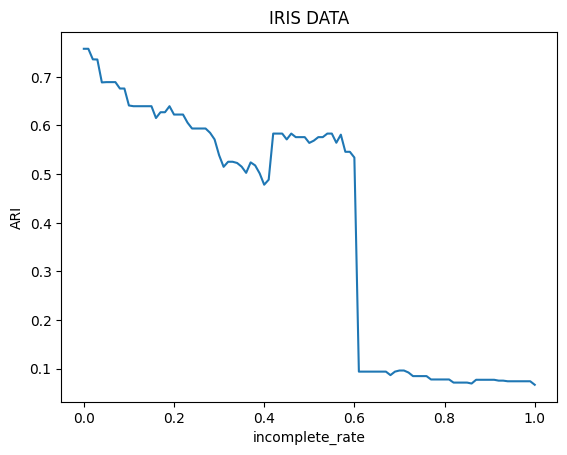

In [87]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example DataFrame
df = iris_results

# Line plot
sns.lineplot(data=df, x='incomplete_rate', y='ARI')
plt.title("IRIS DATA")
plt.show()